- https://developers.google.com/earth-engine/datasets/catalog/CSP_ERGo_1_0_US_lithology

In [1]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("default") 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd

import geopandas as gpd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString, Polygon, mapping

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.crs import CRS
from rasterio.io import MemoryFile
import tempfile

In [2]:
# Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_NA_TX_Data')
# Shapes
tx = gpd.read_file('Texas_State_Boundary')
tx_co = gpd.read_file('Texas_County_Boundaries_Detailed')
tx_watershed = gpd.read_file('tx_watershed')
Counties_1 = gpd.read_file('Counties_1')
Counties_1_Merged = gpd.read_file('Counties_1_Merged')
Hockly_HUCs = gpd.read_file('Hockly_HUCs')

In [3]:
# Define the coordinates
coords = (30.086982, -95.763325)
# Create a Point geometry
geometry = [Point(coords[::-1])]  # Note: Point takes in (x, y) so we reverse the tuple
# Create a GeoDataFrame
sample_location = gpd.GeoDataFrame({'geometry': geometry}, crs="EPSG:4326")

# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
sample_location_reprojected = sample_location.to_crs(raster_crs)

In [4]:
# Watershed Boundaries
huc8 = "J:///Chomiak_Python/Chomiak_Notebooks/Maps_NA_TX_Data/USGS_HUC_8_Shapefile.zip"    # HUC8
huc8 = gpd.read_file(huc8)    # HUC8
huc8.crs = CRS.from_epsg(4326)       # Change the CRS of the File (Previously 4269)

# San Jacinto Basin (HUC = 120401)  
h1 = huc8[huc8['HUC_8'] == '12040101']
h2 = huc8[huc8['HUC_8'] == '12040102']
h3 = huc8[huc8['HUC_8'] == '12040103']
h4 = huc8[huc8['HUC_8'] == '12040104']

# List of Relevant Tags
huc = ['12040101', '12040102', '12040103', '12040104']

# Concatenate the dfs
huc = gpd.pd.concat([h1,h2,h3,h4])

# Create a Boundary Shape for Plots
polygon = huc.geometry.unary_union
mask_huc = gpd.GeoDataFrame(geometry=[polygon])

print(list(huc['SUBBASIN'].unique())) # Sub-Basins

['West Fork San Jacinto', 'Spring', 'East Fork San Jacinto', 'Buffalo-San Jacinto']


In [5]:
# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
h2_reprojected = h2.to_crs(raster_crs)

In [6]:
# HydroSHEDS (4326)
HydroRIVERS_TX_SJRB_Spring = gpd.read_file('HydroRIVERS_TX_SJRB_Spring')
flow_5 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 5]
flow_6 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 6]
flow_7 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 7]

# HydroSHEDS (AEA)
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
HydroRIVERS_TX_SJRB_Spring_reprojected = HydroRIVERS_TX_SJRB_Spring.to_crs(raster_crs)

rflow_5 = HydroRIVERS_TX_SJRB_Spring_reprojected.loc[HydroRIVERS_TX_SJRB_Spring_reprojected['ORD_FLOW'] == 5]
rflow_6 = HydroRIVERS_TX_SJRB_Spring_reprojected.loc[HydroRIVERS_TX_SJRB_Spring_reprojected['ORD_FLOW'] == 6]
rflow_7 = HydroRIVERS_TX_SJRB_Spring_reprojected.loc[HydroRIVERS_TX_SJRB_Spring_reprojected['ORD_FLOW'] == 7]

In [7]:
df = pd.read_csv('NLCD_2019_Attribute_Tables.csv')

# Extract colors from table
colors = df['Color'].tolist()
# Create the colormap
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(df['Value'].tolist(), cmap.N)

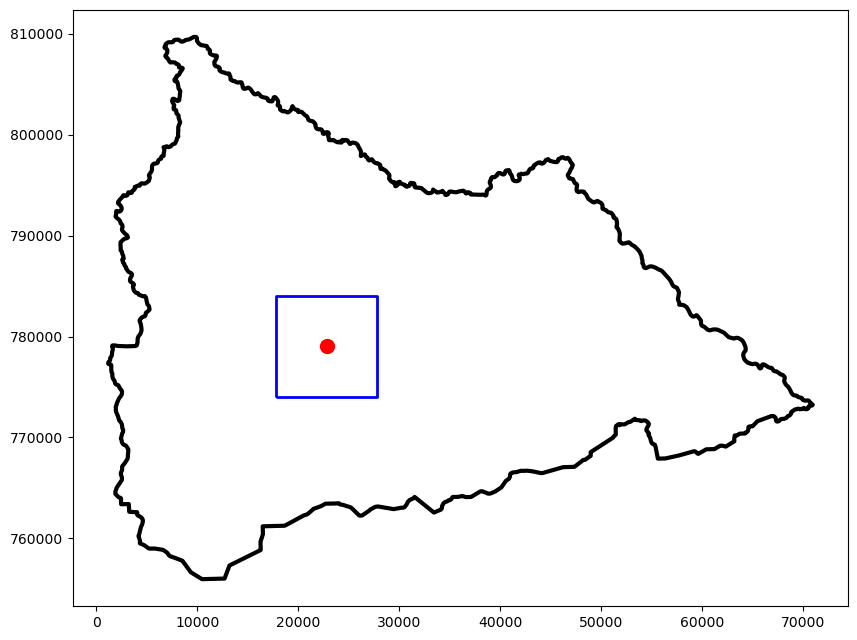

In [8]:
# Define the buffer distance (half of 5km for each side)
buffer_distance = 10000 / 2

# Create the buffer around the point and then get its bounding rectangle
bounding_box = sample_location_reprojected.buffer(buffer_distance).envelope

# Now, you can plot this bounding box:
fig, ax = plt.subplots(figsize=(10, 10))
h2_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=3)
sample_location_reprojected.plot(ax=ax, color='red', markersize=100)
bounding_box.plot(ax=ax, color='none', edgecolor='blue', lw=2)
plt.show()


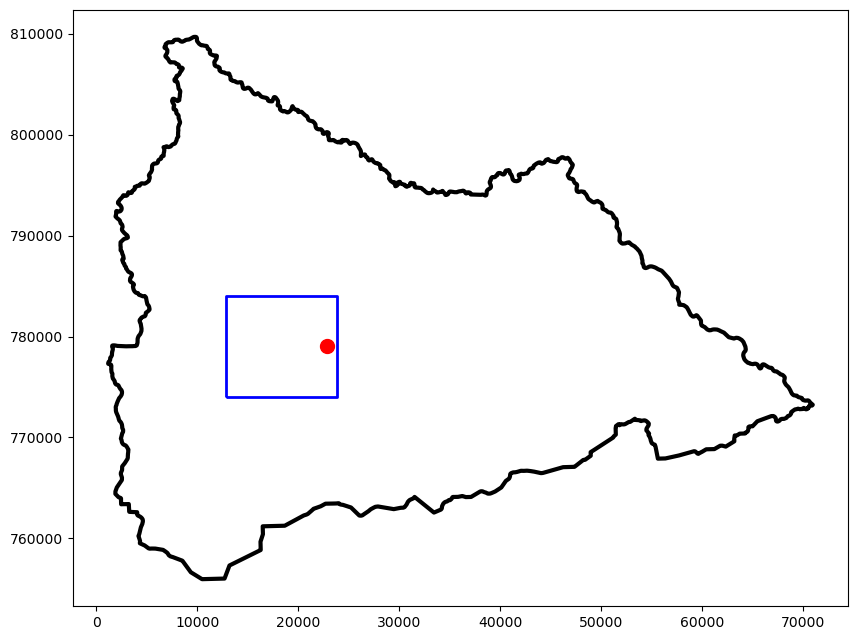

In [9]:
from shapely.geometry import Polygon

# Extract the x and y coordinates of the reprojected point
x, y = sample_location_reprojected.geometry.x.values[0], sample_location_reprojected.geometry.y.values[0]

# Define the new bounding box coordinates
left = x - 10000
right = x + 1000  # Just slightly more than the point's x-coordinate
bottom = y - 5000
top = y + 5000

# Create the Polygon and convert to GeoDataFrame
bounding_box = gpd.GeoDataFrame(
    {'geometry': [Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])]},
    crs=sample_location_reprojected.crs
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
h2_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=3)
sample_location_reprojected.plot(ax=ax, color='red', markersize=100)
bounding_box.plot(ax=ax, color='none', edgecolor='blue', lw=2)
plt.show()


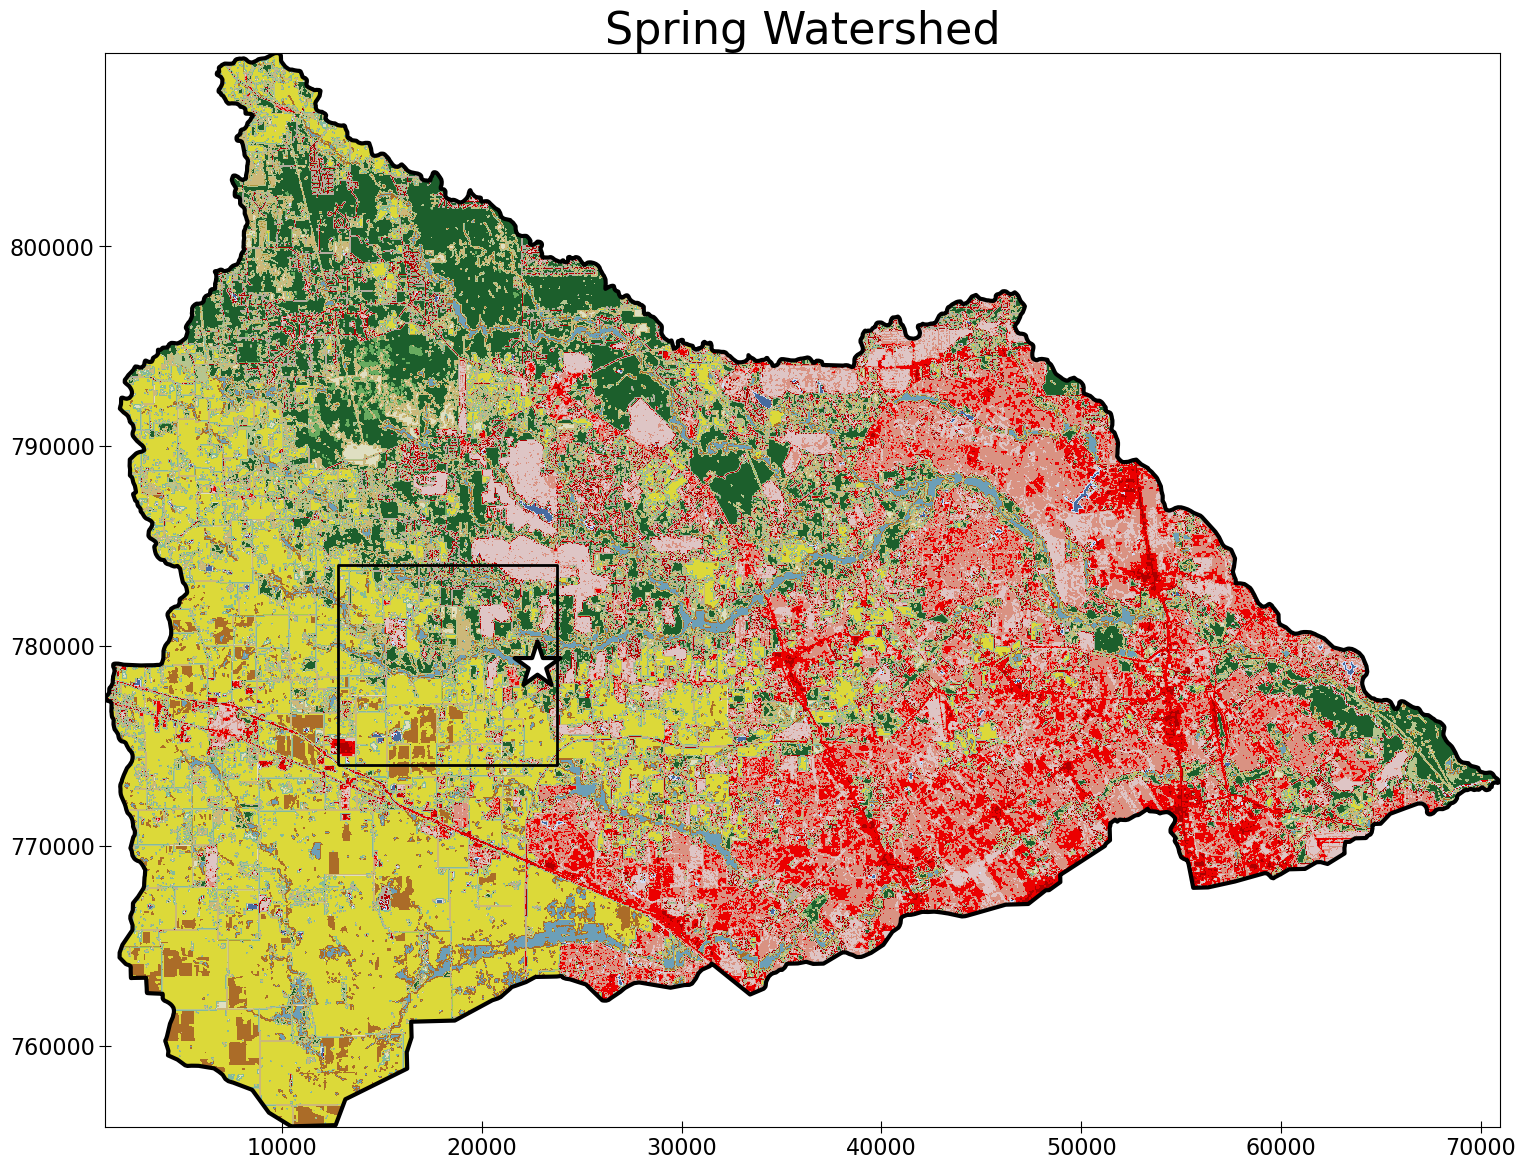

In [10]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring.img") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)

# Shapes
h2_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
bounding_box.plot(ax=ax, color='none', edgecolor='black', lw=2)
#HydroRIVERS_TX_SJRB_Spring_reprojected.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

#fig.savefig("Chomiak_TX_Images_2023\TX_NLCD_Sample_Location_0.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

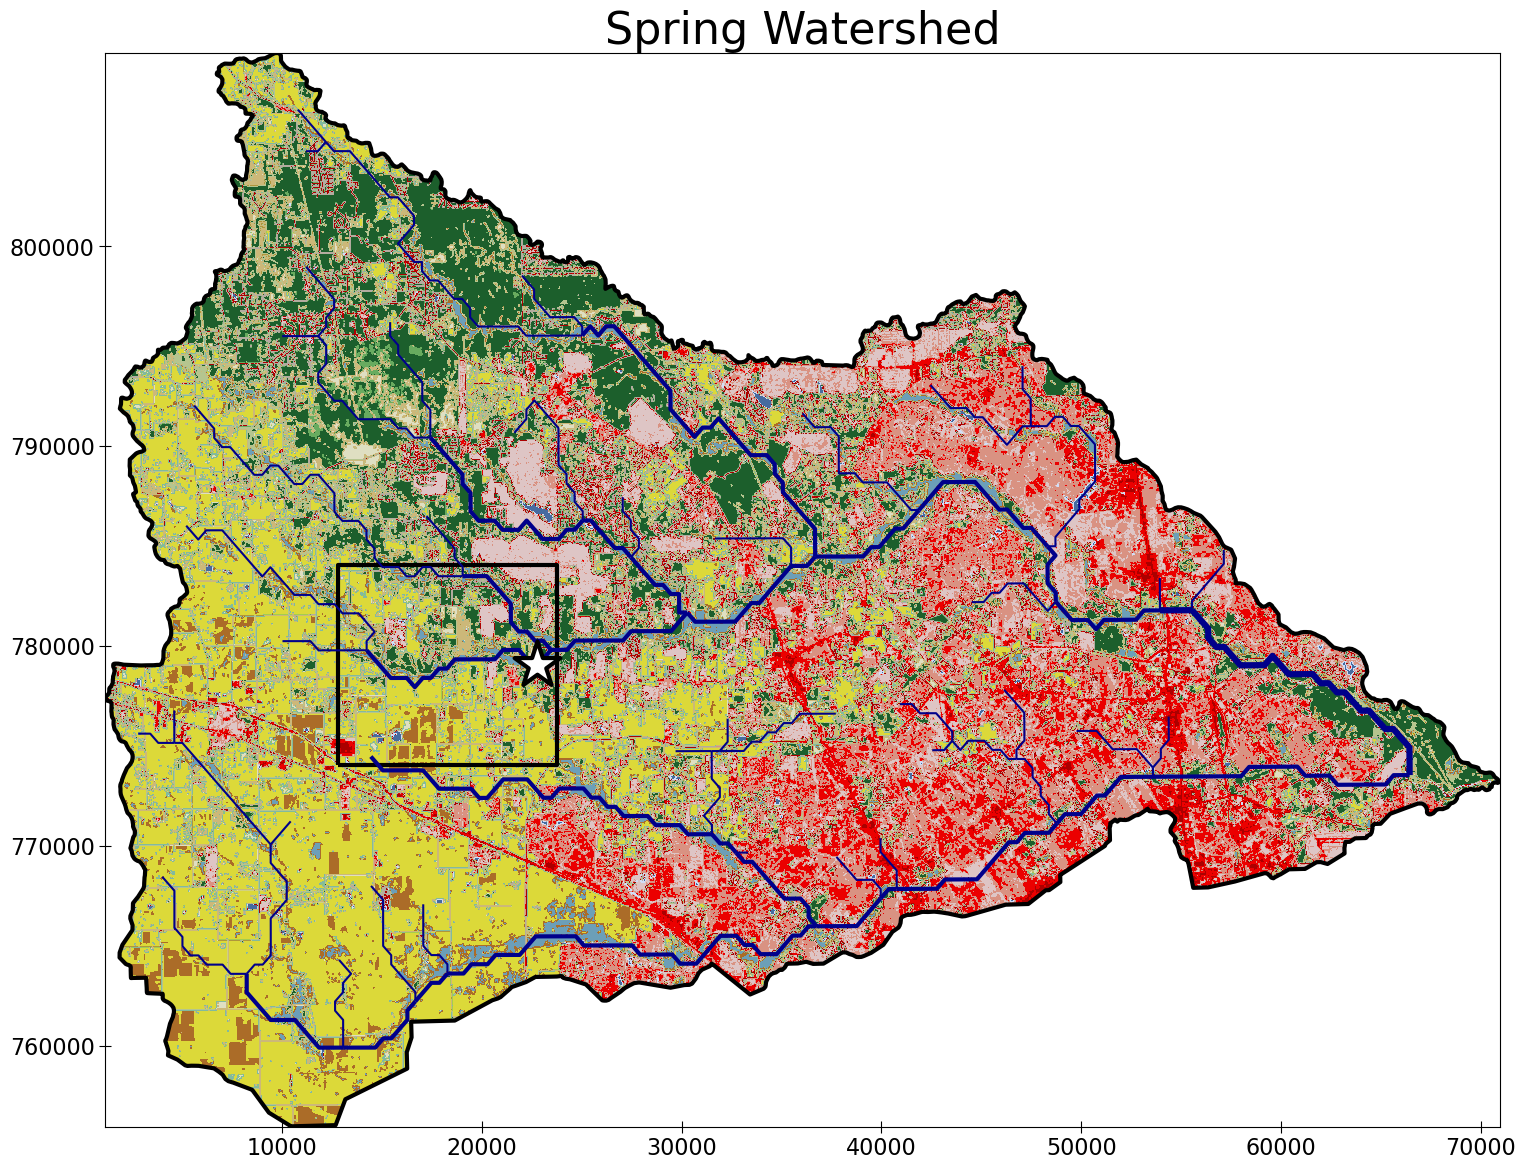

In [11]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring.img") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Shapes
h2_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1200, lw=3, zorder=6)
bounding_box.plot(ax=ax, color='none', edgecolor='black', lw=3)
rflow_5.plot(ax=ax, color='darkblue', lw=4.5, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
rflow_6.plot(ax=ax, color='darkblue', lw=3.0, zorder=4, label='10$^0$ - 10$^1$ [m$^3$/s]')
rflow_7.plot(ax=ax, color='darkblue', lw=1.5, zorder=3, label='10$^{-1}$ - 10$^0$ [m$^3$/s]')

fig.savefig("Chomiak_TX_Images_2023\TX_NLCD_Sample_Location_00.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [12]:
bounding_box_epsg_4326 = bounding_box.to_crs(epsg=4326)
bounding_box_epsg_4326.to_file("bounding_box_epsg_4326.shp")


# Clip to Box

In [ ]:
#with rasterio.open('NLCD_2019_HUC_SJRB_Spring.img') as src:
#    # Clip the raster
#    clipped_image, clipped_transform = mask(src, bounding_box.geometry, crop=True)
#    clipped_meta = src.meta
#    
#    # Update metadata after clipping
#    clipped_meta.update({
#        "driver": "GTiff",
#        "height": clipped_image.shape[1],
#        "width": clipped_image.shape[2],
#        "transform": clipped_transform
#    })
#    
#    # Save the clipped raster
#    with rasterio.open('NLCD_2019_HUC_SJRB_Spring_Box2.img', "w", **clipped_meta) as dest:
#        dest.write(clipped_image)

# Display

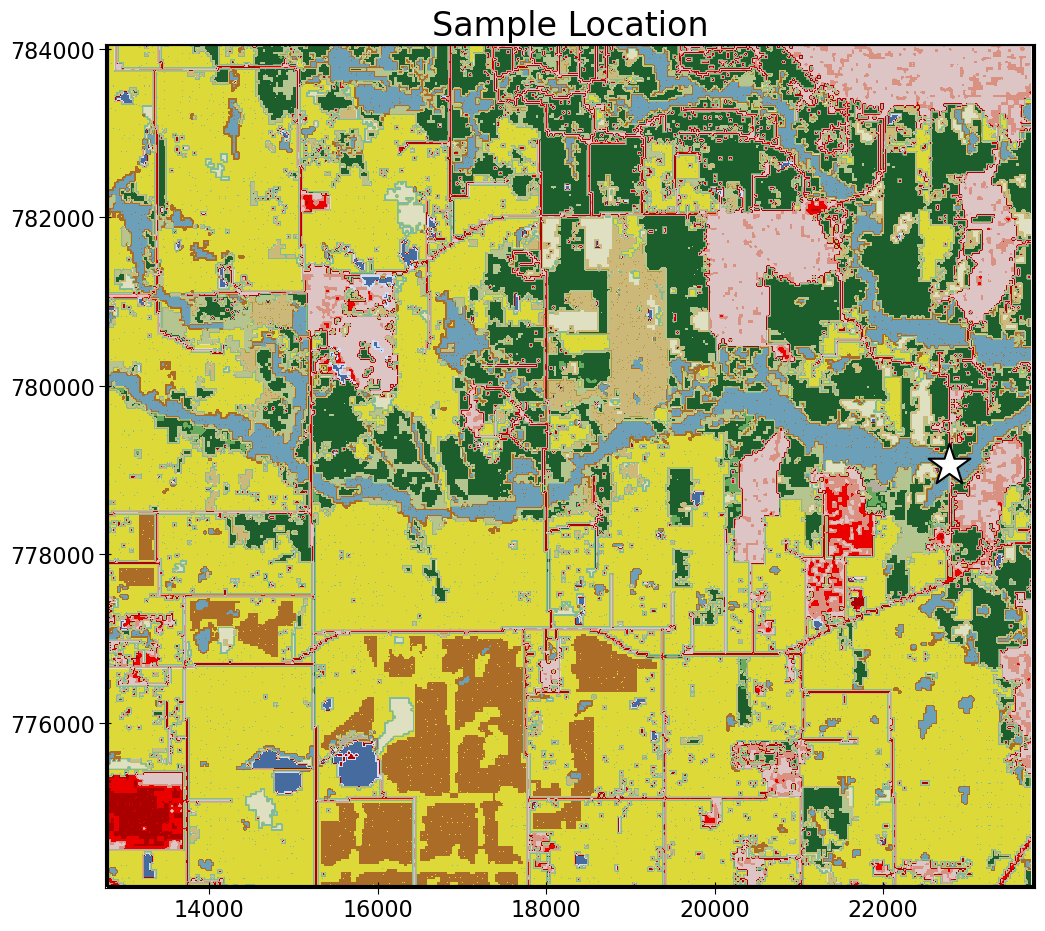

In [14]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring_Box2.img") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Set title and labels
ax.set_title('Sample Location', fontsize=24)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)

# Shapes
bounding_box.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location_reprojected.plot(ax=ax, color='white', edgecolor='black', lw=1.5, zorder=6, 
                                 marker='*', markersize=1000)

#HydroRIVERS_TX_SJRB_Spring_reprojected.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

#fig.savefig("Chomiak_TX_Images_2023\TX_NLCD_Sample_Location_1.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [15]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring_Box2.img") as src:
    # Read the raster data
    img_data = src.read(1)
    # Get the resolution (assumes square pixels)
    pixel_size = abs(src.transform[0] * src.transform[4])
    # Count the unique values (excluding nodata)
    unique_values, counts = np.unique(img_data[img_data != src.nodata], return_counts=True)

# Convert pixel counts to areas
areas = counts * pixel_size
# Create a DataFrame
df_box = pd.DataFrame({
    'Land_Class_Value': unique_values,
    'Pixel_Count': counts,
    'Area_m2': areas
})

# Use the map function to map the Land_Class_Value to its corresponding Name
df_box['Name'] = df_box['Land_Class_Value'].map(df.set_index('Value')['Name'])
df_box['Color'] = df_box['Land_Class_Value'].map(df.set_index('Value')['Color'])

# Calculate the total area for Shapefile and Raster File
total_area_m2 = bounding_box.geometry.area.sum()
relative_area_m2 = df_box['Area_m2'].sum()

# Calculate distributions for Shapefile and Raster File
df_box['rel_distribution'] = (df_box['Area_m2'] / relative_area_m2)*100
df_box['total_distribution'] = (df_box['Area_m2'] / total_area_m2)*100

In [16]:
df_box = df_box.sort_values(by='Area_m2', ascending=False)

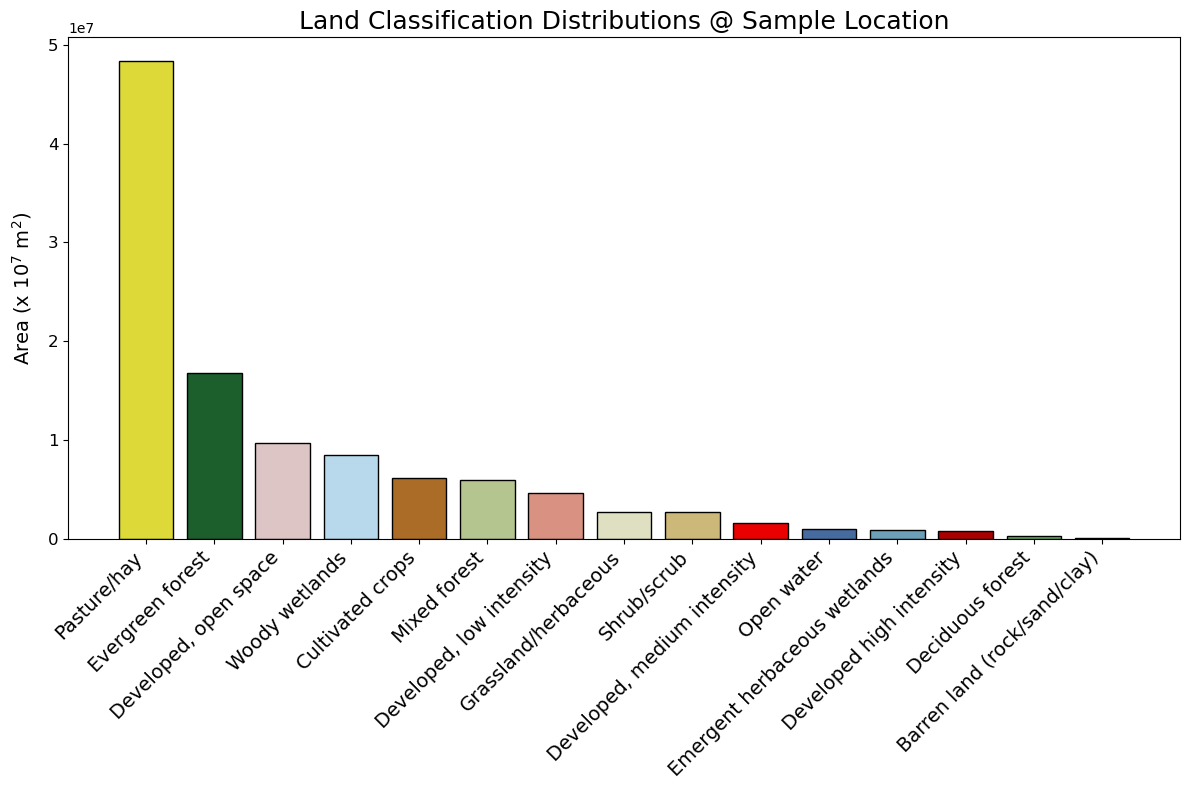

In [17]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df_box['Name'], df_box['Area_m2'], color=df_box['Color'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Land Classification Distributions @ Sample Location', fontsize=18)
ax.set_ylabel('Area (x $10^7$ m$^2$)', fontsize=14, labelpad=10)
#ax.set_xlabel('Soil Taxonomic Classes', fontsize=14)

# Rotate x labels for better readability
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=12)
fig.tight_layout()

fig.savefig("Chomiak_TX_Images_2023\2019_NLCD_Sample_Location_Barplot.png", dpi=600, bbox_inches='tight')

In [18]:
df_box

,Land_Class_Value,Pixel_Count,Area_m2,Name,Color,rel_distribution,total_distribution
11,81,53728,48355200.0,Pasture/hay,#dcd939,43.951441,43.959273
7,42,18611,16749900.0,Evergreen forest,#1c5f2c,15.224469,15.227182
1,21,10721,9648900.0,"Developed, open space",#dec5c5,8.770165,8.771727
13,90,9447,8502300.0,Woody wetlands,#b8d9eb,7.727987,7.729364
12,82,6820,6138000.0,Cultivated crops,#ab6c28,5.579006,5.580000
8,43,6621,5958900.0,Mixed forest,#b5c58f,5.416217,5.417182
2,22,5118,4606200.0,"Developed, low intensity",#d99282,4.186709,4.187455
10,71,3023,2720700.0,Grassland/herbaceous,#dfdfc2,2.472923,2.473364
9,52,2974,2676600.0,Shrub/scrub,#ccb879,2.432839,2.433273
3,23,1787,1608300.0,"Developed, medium intensity",#eb0000,1.461830,1.462091


In [13]:
halt

NameError: name 'halt' is not defined

In [ ]:
Hydrosheds_na_conditioned_dem_3s